In [5]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [6]:
print(tf.__version__)

2.10.0


In [7]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [9]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [10]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .80)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [11]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [12]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(sampling_strategy=.90)
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

0    649
1     62
Name: binding, dtype: int64
0    73
1    16
Name: binding, dtype: int64


In [13]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

0    649
1    584
Name: binding, dtype: int64
0    73
1    16
Name: binding, dtype: int64


In [14]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [15]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [16]:
print(training_split.shape)
print(test_split.shape)

(1233, 81953)
(89, 81953)


In [17]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [18]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [19]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [20]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(4 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return np.array(new_train_data), np.array(new_train_res)

In [21]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( 5 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [22]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.prevous = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')
        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if self.prevous == None:
            self.prevous = self.f1_train
        if self.prevous == self.f1_train:
            self.count += 1
        else:
            self.prevous = self.f1_train
            self.count = 0
        if self.count == 5:
            self.model.stop_training = True
            print('\n\n******* No improvements *******')
        if abs(self.f1_train) > .85:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [23]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [24]:
ensemble_size = 12
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 50
        print( "bfore traning: ", ((sum(train_res)/len(train_res)))*100)
        history = model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = 0.2 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [25]:
# plt.plot(initial_weight)
boosting(initial_weight)

2022-11-10 03:08:20.481138: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-10 03:08:20.486400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
bfore traning:  47.99675587996756
Epoch 1/50


2022-11-10 03:08:21.768672: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-10 03:08:22.032063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 2s 18ms/step - loss: 1.2113 - tp: 2276.0000 - fp: 139.0000 - tn: 3067.0000 - fn: 683.0000 - precision: 0.9424 - recall: 0.7692
Epoch 2/50
89/89 [==============================] - 1s 17ms/step - loss: 0.4914 - tp: 2083.0000 - fp: 78.0000 - tn: 3128.0000 - fn: 876.0000 - precision: 0.9639 - recall: 0.7040
Epoch 3/50
89/89 [==============================] - 1s 16ms/step - loss: 0.4864 - tp: 2129.0000 - fp: 73.0000 - tn: 3133.0000 - fn: 830.0000 - precision: 0.9668 - recall: 0.7195
Epoch 4/50
89/89 [==============================] - 1s 17ms/step - loss: 0.4891 - tp: 2126.0000 - fp: 75.0000 - tn: 3131.0000 - fn: 833.0000 - precision: 0.9659 - recall: 0.7185
Epoch 5/50
89/89 [==============================] - 1s 16ms/step - loss: 0.4900 - tp: 2186.0000 - fp: 74.0000 - tn: 3132.0000 - fn: 773.0000 - precision: 0.9673 - recall: 0.7388
Epoch 6/50
89/89 [==============================] - ETA: 0s - loss: 0.4845 - tp: 2278.0000 - fp: 73.0000 - tn: 3133.0000

2022-11-10 03:08:31.744675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 5ms/step
0.7257203842049093
0.7915652879156528
error_rate: 0.0001690468062322365
0.9999999999999812
bfore traning:  88.71046228710462
Epoch 1/50


2022-11-10 03:08:34.877307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 1.2153 - tp: 5251.0000 - fp: 658.0000 - tn: 38.0000 - fn: 218.0000 - precision: 0.8886 - recall: 0.9601

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9230093302649133
89/89 [==============================] - 2s 23ms/step - loss: 1.2153 - tp: 5251.0000 - fp: 658.0000 - tn: 38.0000 - fn: 218.0000 - precision: 0.8886 - recall: 0.9601



****** Early Stopping *******
16/39 [===========>..................] - ETA: 0s

2022-11-10 03:08:37.506076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.6231155778894473
0.45255474452554745
error_rate: 0.000165765606204202
1.0000000000000129
bfore traning:  50.08921330089213
Epoch 1/50


2022-11-10 03:08:40.850444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 2s 22ms/step - loss: 1.1688 - tp: 2490.0000 - fp: 281.0000 - tn: 2796.0000 - fn: 598.0000 - precision: 0.8986 - recall: 0.8063
Epoch 2/50
87/89 [============================>.] - ETA: 0s - loss: 0.4148 - tp: 2443.0000 - fp: 31.0000 - tn: 3010.0000 - fn: 606.0000 - precision: 0.9875 - recall: 0.8012

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8850759458743261
89/89 [==============================] - 2s 20ms/step - loss: 0.4147 - tp: 2476.0000 - fp: 31.0000 - tn: 3046.0000 - fn: 612.0000 - precision: 0.9876 - recall: 0.8018



****** Early Stopping *******
17/39 [============>.................] - ETA: 0s

2022-11-10 03:08:45.266640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.20121951219512194
0.5750202757502028
error_rate: 7.381740503782987e-05
0.9999999999999887
bfore traning:  88.24006488240065
Epoch 1/50


2022-11-10 03:08:48.397664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 1.1595 - tp: 5399.0000 - fp: 708.0000 - tn: 17.0000 - fn: 41.0000 - precision: 0.8841 - recall: 0.9925

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9351346719868904
89/89 [==============================] - 2s 22ms/step - loss: 1.1595 - tp: 5399.0000 - fp: 708.0000 - tn: 17.0000 - fn: 41.0000 - precision: 0.8841 - recall: 0.9925



****** Early Stopping *******
24/39 [=================>............] - ETA: 0s

2022-11-10 03:08:51.040208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.6428178315905339
0.47364152473641524
error_rate: 0.0001008737517982596
1.0000000000000042
bfore traning:  15.085158150851582
Epoch 1/50


2022-11-10 03:08:54.218184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 2s 22ms/step - loss: 1.2128 - tp: 166.0000 - fp: 215.0000 - tn: 5020.0000 - fn: 764.0000 - precision: 0.4357 - recall: 0.1785
Epoch 2/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4620 - tp: 42.0000 - fp: 2.0000 - tn: 5233.0000 - fn: 888.0000 - precision: 0.9545 - recall: 0.0452
Epoch 3/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4533 - tp: 8.0000 - fp: 17.0000 - tn: 5218.0000 - fn: 922.0000 - precision: 0.3200 - recall: 0.0086
Epoch 4/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4386 - tp: 9.0000 - fp: 0.0000e+00 - tn: 5235.0000 - fn: 921.0000 - precision: 1.0000 - recall: 0.0097
Epoch 5/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4336 - tp: 20.0000 - fp: 0.0000e+00 - tn: 5235.0000 - fn: 910.0000 - precision: 1.0000 - recall: 0.0215
Epoch 6/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4311 - tp: 19.0000 - fp: 0.0000e+00 - tn: 5235.0000

2022-11-10 03:10:24.667285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.4038199181446112
0.6455798864557989
error_rate: 3.5881666976810835e-05
1.0000000000000082
bfore traning:  75.47445255474453
Epoch 1/50


2022-11-10 03:10:28.101589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 1.1680 - tp: 4589.0000 - fp: 1498.0000 - tn: 14.0000 - fn: 64.0000 - precision: 0.7539 - recall: 0.9862

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8545624052441517
89/89 [==============================] - 2s 19ms/step - loss: 1.1680 - tp: 4589.0000 - fp: 1498.0000 - tn: 14.0000 - fn: 64.0000 - precision: 0.7539 - recall: 0.9862



****** Early Stopping *******
22/39 [===============>..............] - ETA: 0s

2022-11-10 03:10:30.415336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 5ms/step
0.6428178315905339
0.47364152473641524
error_rate: 0.00019935376978167003
1.0000000000000109
bfore traning:  9.115977291159773
Epoch 1/50


2022-11-10 03:10:33.525870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 23ms/step - loss: 1.2188 - tp: 104.0000 - fp: 66.0000 - tn: 5537.0000 - fn: 458.0000 - precision: 0.6118 - recall: 0.1851
Epoch 2/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4516 - tp: 103.0000 - fp: 0.0000e+00 - tn: 5603.0000 - fn: 459.0000 - precision: 1.0000 - recall: 0.1833
Epoch 3/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4313 - tp: 111.0000 - fp: 0.0000e+00 - tn: 5603.0000 - fn: 451.0000 - precision: 1.0000 - recall: 0.1975
Epoch 4/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4321 - tp: 128.0000 - fp: 17.0000 - tn: 5586.0000 - fn: 434.0000 - precision: 0.8828 - recall: 0.2278
Epoch 5/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4048 - tp: 113.0000 - fp: 0.0000e+00 - tn: 5603.0000 - fn: 449.0000 - precision: 1.0000 - recall: 0.2011
Epoch 6/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4001 - tp: 127.0000 - fp: 0.0000e+00 - tn:

2022-11-10 03:12:04.024259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.3072463768115942
0.6123276561232766
error_rate: 1.4722178119818436e-05
1.000000000000003
bfore traning:  62.87104622871046
Epoch 1/50


2022-11-10 03:12:07.248466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 23ms/step - loss: 1.2009 - tp: 3700.0000 - fp: 2094.0000 - tn: 195.0000 - fn: 176.0000 - precision: 0.6386 - recall: 0.9546
Epoch 2/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4767 - tp: 3876.0000 - fp: 2289.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.6287 - recall: 1.0000
Epoch 3/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4728 - tp: 3876.0000 - fp: 2288.0000 - tn: 1.0000 - fn: 0.0000e+00 - precision: 0.6288 - recall: 1.0000
Epoch 4/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4715 - tp: 3876.0000 - fp: 2278.0000 - tn: 11.0000 - fn: 0.0000e+00 - precision: 0.6298 - recall: 1.0000
Epoch 5/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4663 - tp: 3872.0000 - fp: 2182.0000 - tn: 107.0000 - fn: 4.0000 - precision: 0.6396 - recall: 0.9990
Epoch 6/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4664 - tp: 3863.0000 - fp: 1905.0000 -

2022-11-10 03:12:22.663496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.6920289855072463
0.5863746958637469
error_rate: 0.00016951108509847816
0.9999999999999953
bfore traning:  10.738037307380372
Epoch 1/50


2022-11-10 03:12:25.808108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 23ms/step - loss: 1.1955 - tp: 99.0000 - fp: 89.0000 - tn: 5414.0000 - fn: 563.0000 - precision: 0.5266 - recall: 0.1495
Epoch 2/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4453 - tp: 36.0000 - fp: 0.0000e+00 - tn: 5503.0000 - fn: 626.0000 - precision: 1.0000 - recall: 0.0544
Epoch 3/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4227 - tp: 10.0000 - fp: 0.0000e+00 - tn: 5503.0000 - fn: 652.0000 - precision: 1.0000 - recall: 0.0151
Epoch 4/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4131 - tp: 7.0000 - fp: 0.0000e+00 - tn: 5503.0000 - fn: 655.0000 - precision: 1.0000 - recall: 0.0106
Epoch 5/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4206 - tp: 41.0000 - fp: 0.0000e+00 - tn: 5503.0000 - fn: 621.0000 - precision: 1.0000 - recall: 0.0619
Epoch 6/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4104 - tp: 61.0000 - fp: 0.0000e+00 - tn: 550

2022-11-10 03:13:56.376918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.6309662398137369
0.7429034874290349
error_rate: 3.3254188082517683e-05
0.9999999999999901
bfore traning:  68.54825628548257
Epoch 1/50


2022-11-10 03:13:59.619877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 1.2133 - tp: 4180.0000 - fp: 852.0000 - tn: 1087.0000 - fn: 46.0000 - precision: 0.8307 - recall: 0.9891

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9030028213538056
89/89 [==============================] - 3s 23ms/step - loss: 1.2133 - tp: 4180.0000 - fp: 852.0000 - tn: 1087.0000 - fn: 46.0000 - precision: 0.8307 - recall: 0.9891



****** Early Stopping *******
17/39 [============>.................] - ETA: 0s

2022-11-10 03:14:02.414085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.6751754945756223
0.5871857258718572
error_rate: 0.00010629620040763783
1.0000000000000038
bfore traning:  13.122465531224655
Epoch 1/50


2022-11-10 03:14:05.558239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 24ms/step - loss: 1.1930 - tp: 123.0000 - fp: 57.0000 - tn: 5299.0000 - fn: 686.0000 - precision: 0.6833 - recall: 0.1520
Epoch 2/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4487 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5356.0000 - fn: 809.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4352 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5356.0000 - fn: 809.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
89/89 [==============================] - 2s 21ms/step - loss: 0.4376 - tp: 8.0000 - fp: 0.0000e+00 - tn: 5356.0000 - fn: 801.0000 - precision: 1.0000 - recall: 0.0099
Epoch 5/50
89/89 [==============================] - 2s 21ms/step - loss: 0.4506 - tp: 18.0000 - fp: 0.0000e+00 - tn: 5356.0000 - fn: 791.0000 - precision: 1.0000 - recall: 0.0222
Epoch 6/50
89/89 [==============================] - 2s 20ms/step - loss: 0.4632 - tp: 47.0000 - f

2022-11-10 03:15:36.499650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.7192982456140351
0.7923763179237632
error_rate: 3.120469635312614e-05
0.9999999999999929
bfore traning:  74.8580697485807
Epoch 1/50


2022-11-10 03:15:40.024831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 1.1720 - tp: 4610.0000 - fp: 1546.0000 - tn: 4.0000 - fn: 5.0000 - precision: 0.7489 - recall: 0.9989

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.856002240344062
89/89 [==============================] - 3s 24ms/step - loss: 1.1720 - tp: 4610.0000 - fp: 1546.0000 - tn: 4.0000 - fn: 5.0000 - precision: 0.7489 - recall: 0.9989



****** Early Stopping *******
16/39 [===========>..................] - ETA: 0s

2022-11-10 03:15:42.985220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 7ms/step
0.6428178315905339
0.47364152473641524
error_rate: 0.0002062139459413871
0.9999999999999848


In [26]:
alphas

[1.7370331720674426,
 1.7409539997811263,
 1.9027684386826396,
 1.8403079852715873,
 2.0470496359529653,
 1.704046040061056,
 2.225228152645437,
 1.7364845418034744,
 2.0622593173368813,
 1.829834943090704,
 2.074982149030914,
 1.6972780240752112]

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# a = ensemble[0].predict(test_split)

def some_pred(test_split, esize):
#     data = []
    k = []
#     for j in range(len(test_split)):
#         pa=0
#         na =0
    for i in range(esize):
        print('*********:', i)
        k.append(ensemble[i].predict([test_split]))
        # if pa >=na:
        #     data.append(1)
        # else:
        #     data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return k

In [28]:

def majority(data):
    ans =[]
    for i in range(len(data[0])):
        ap = 0
        an = 0
        for e in range(len(data)):
            if data[e][i] >= .5:
                ap += alphas[e]
            else:
                an += alphas[e]
        if ap >= an:
            ans.append(1)
        else:
            ans.append(0)
    return ans


*********: 0
3/3 [==============================] - 0s 12ms/step
*********: 1
3/3 [==============================] - 0s 6ms/step
*********: 2
3/3 [==============================] - 0s 8ms/step
*********: 3
3/3 [==============================] - 0s 6ms/step
*********: 4
3/3 [==============================] - 0s 9ms/step
*********: 5
3/3 [==============================] - 0s 9ms/step
*********: 6
3/3 [==============================] - 0s 15ms/step
*********: 7
3/3 [==============================] - 0s 16ms/step


2022-11-10 03:18:37.736399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 03:18:37.836187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 8
3/3 [==============================] - 0s 17ms/step
*********: 9
3/3 [==============================] - 0s 12ms/step
*********: 10


2022-11-10 03:18:37.943936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 03:18:38.046079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 16ms/step
*********: 11
3/3 [==============================] - 0s 13ms/step


2022-11-10 03:18:38.154549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 03:18:38.260254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


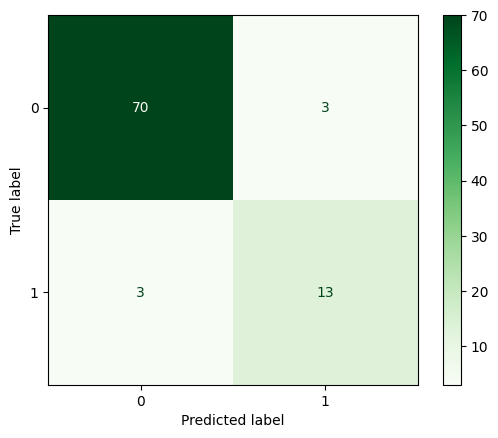

In [32]:
data = some_pred(test_split, 12)
ans = majority(data)
ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')


In [33]:
ans

[0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

*********: 0
39/39 [==============================] - 0s 5ms/step
*********: 1
39/39 [==============================] - 0s 5ms/step
*********: 2
39/39 [==============================] - 0s 5ms/step
*********: 3
39/39 [==============================] - 0s 6ms/step
*********: 4
39/39 [==============================] - 0s 6ms/step
*********: 5
39/39 [==============================] - 0s 5ms/step
*********: 6
39/39 [==============================] - 0s 5ms/step
*********: 7
39/39 [==============================] - 0s 5ms/step
*********: 8
39/39 [==============================] - 0s 5ms/step
*********: 9
39/39 [==============================] - 0s 5ms/step
*********: 10
39/39 [==============================] - 0s 7ms/step
*********: 11
39/39 [==============================] - 0s 7ms/step


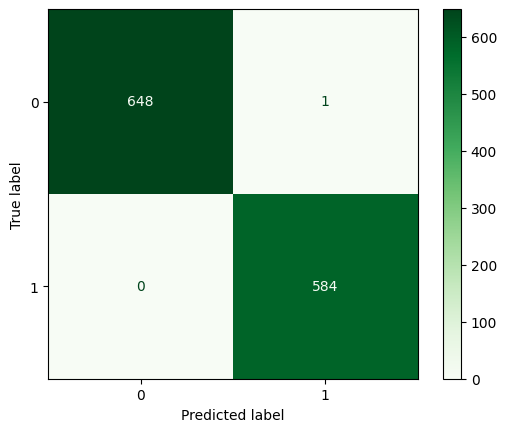

In [34]:
data = some_pred(training_split, 12)
ans = majority(data)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [35]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = majority(some_pred(unlabeled_test, 12))

*********: 0
11/11 [==============================] - 0s 8ms/step
*********: 1
11/11 [==============================] - 0s 7ms/step
*********: 2
11/11 [==============================] - 0s 6ms/step
*********: 3
11/11 [==============================] - 0s 6ms/step
*********: 4
11/11 [==============================] - 0s 6ms/step
*********: 5
11/11 [==============================] - 0s 6ms/step
*********: 6
11/11 [==============================] - 0s 6ms/step
*********: 7
11/11 [==============================] - 0s 6ms/step
*********: 8
11/11 [==============================] - 0s 7ms/step
*********: 9
11/11 [==============================] - 0s 7ms/step
*********: 10
11/11 [==============================] - 0s 6ms/step
*********: 11
11/11 [==============================] - 0s 8ms/step


In [37]:
len(predicted_data)
predicted_data

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [38]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_data))
outfile.close()